In [1]:
from datasets import load_dataset
ds = load_dataset("jxie/flickr8k")
print(ds)

DatasetDict({
    train: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 6000
    })
    validation: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['image', 'caption_0', 'caption_1', 'caption_2', 'caption_3', 'caption_4'],
        num_rows: 1000
    })
})


# Vocabulary & Tokenizer

In [2]:
import re
from collections import Counter

# Basic tokenizer
def basic_english(text):
    return re.findall(r"\w+|[^\w\s]", text.lower())

# Vocabulary class
class Vocab:
    def __init__(self, counter, specials):
        self.itos = specials + sorted([tok for tok in counter if tok not in specials])
        self.stoi = {tok: idx for idx, tok in enumerate(self.itos)}
        self.unk_index = self.stoi.get("<unk>", 0)

    def __getitem__(self, token):
        return self.stoi.get(token, self.unk_index)

    def __len__(self):
        return len(self.itos)

    def get_itos(self):
        return self.itos

    def set_default_index(self, index):
        self.unk_index = index


# Build Vocab from All 5 Captions

In [3]:
# Yield tokens from all captions
def yield_tokens(dataset):
    for sample in dataset:
        for i in range(5):
            yield basic_english(sample[f'caption_{i}'])

# Build vocab
counter = Counter()
for tokens in yield_tokens(ds["train"]):
    counter.update(tokens)

specials = ["<unk>", "<pad>", "<bos>", "<eos>"]
vocab_obj = Vocab(counter, specials)
vocab_obj.set_default_index(vocab_obj["<unk>"])

print(f"Vocabulary size: {len(vocab_obj)}")
print("Example tokens:", vocab_obj.get_itos()[:20])


Vocabulary size: 7387
Example tokens: ['<unk>', '<pad>', '<bos>', '<eos>', '!', '"', '#', '&', "'", '(', ')', ',', '-', '.', '1', '10', '104', '11', '12', '13']


# Define Dataset & DataLoader Using All 5 Captions

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# Custom Dataset
class CaptionDataset(Dataset):
    def __init__(self, dataset, vocab, tokenizer):
        self.samples = []
        self.vocab = vocab
        self.tokenizer = tokenizer

        for item in dataset:
            for i in range(5):  # Use all 5 captions
                caption = item[f'caption_{i}']
                self.samples.append((item['image'], caption))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, caption = self.samples[idx]
        tokens = self.tokenizer(caption)
        numericalized = [self.vocab["<bos>"]] + [self.vocab[t] for t in tokens] + [self.vocab["<eos>"]]
        return torch.tensor(numericalized), image

# Collate function
def collate_fn(batch):
    captions, images = zip(*batch)
    padded = pad_sequence(captions, batch_first=True, padding_value=vocab_obj["<pad>"])
    return padded, images

# Setup DataLoader
train_data = CaptionDataset(ds["train"], vocab_obj, basic_english)
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Preview one batch
for padded_captions, image_refs in train_loader:
    print("Batch shape:", padded_captions.shape)
    break


Batch shape: torch.Size([4, 16])


# EncoderCNN (ResNet18)

In [5]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

class EncoderCNN(nn.Module):
    """
    Encoder that returns a spatial feature map for attention.
    Output shape: (batch_size, num_pixels, encoder_dim)
    where num_pixels = encoded_image_size * encoded_image_size
    """
    def __init__(self, encoder_dim=256, encoded_image_size=14):
        super(EncoderCNN, self).__init__()
        self.encoded_image_size = encoded_image_size

        resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # remove avgpool and fc -> keep conv feature map
        modules = list(resnet.children())[:-2]
        self.backbone = nn.Sequential(*modules)

        # Adapt spatial size to encoded_image_size x encoded_image_size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((encoded_image_size, encoded_image_size))

        # project ResNet channels (512) to encoder_dim
        self.conv = nn.Conv2d(512, encoder_dim, kernel_size=1)
        self.bn = nn.BatchNorm2d(encoder_dim)

        # you can freeze most of resnet at first
        for p in self.backbone.parameters():
            p.requires_grad = True

    def forward(self, images):
        """
        images: (batch_size, 3, H, W)
        returns: encoder_out: (batch_size, num_pixels, encoder_dim)
        """
        x = self.backbone(images)                               # (B, 512, H', W')
        x = self.adaptive_pool(x)                               # (B, 512, encoded_image_size, encoded_image_size)
        x = self.conv(x)                                        # (B, encoder_dim, H, W)
        x = self.bn(x)
        x = x.permute(0, 2, 3, 1)                               # (B, H, W, encoder_dim)
        batch_size, H, W, encoder_dim = x.size()
        x = x.view(batch_size, -1, encoder_dim)                 # (B, num_pixels, encoder_dim)
        return x


In [6]:
class Attention(nn.Module):
    """
    Soft additive (Bahdanau) attention.
    encoder_out: (B, num_pixels, encoder_dim)
    decoder_hidden: (B, decoder_dim)
    """
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        # encoder_out: (B, num_pixels, encoder_dim)
        # decoder_hidden: (B, decoder_dim)
        att1 = self.encoder_att(encoder_out)                    # (B, num_pixels, att_dim)
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)    # (B, 1, att_dim)
        att = self.full_att(self.relu(att1 + att2)).squeeze(2)  # (B, num_pixels)
        alpha = self.softmax(att)                               # (B, num_pixels)
        context = (encoder_out * alpha.unsqueeze(2)).sum(dim=1) # (B, encoder_dim)
        return context, alpha


# DecoderRNN (LSTM Caption Generator)

In [7]:
class DecoderWithAttention(nn.Module):
    def __init__(
        self,
        attention_dim,
        embed_dim,
        decoder_dim,
        vocab_size,
        encoder_dim=256,    # must match EncoderCNN encoder_dim
        dropout=0.5
    ):
        super(DecoderWithAttention, self).__init__()

        self.encoder_dim = encoder_dim
        self.attention_dim = attention_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.attention = Attention(encoder_dim, decoder_dim, attention_dim)

        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout_layer = nn.Dropout(dropout)

        # LSTMCell instead of LSTM to step manually
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)

        # initialize hidden/cell from mean of encoder features
        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)

        # gating (as in Show-Attend-and-Tell)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()

        self.fc = nn.Linear(decoder_dim, vocab_size)

    def init_hidden_state(self, encoder_out):
        mean_encoder = encoder_out.mean(dim=1)         # (B, encoder_dim)
        h = self.init_h(mean_encoder)                  # (B, decoder_dim)
        c = self.init_c(mean_encoder)
        return h, c

    def forward(self, encoder_out, captions):
        """
        encoder_out: (B, num_pixels, encoder_dim)
        captions: (B, max_len)  (already numericalized with <bos>/<eos>)
        Returns: predictions: (B, max_len-1, vocab_size)
        """
        batch_size = encoder_out.size(0)
        num_pixels = encoder_out.size(1)
        max_len = captions.size(1)

        # we'll predict words 1..(max_len-1) using inputs 0..(max_len-2)
        embeddings = self.embedding(captions)          # (B, max_len, embed_dim)

        h, c = self.init_hidden_state(encoder_out)

        predictions = torch.zeros(batch_size, max_len - 1, self.vocab_size, device=encoder_out.device)

        for t in range(max_len - 1):
            emb_t = embeddings[:, t, :]                # (B, embed_dim)

            context, alpha = self.attention(encoder_out, h)    # (B, encoder_dim), (B, num_pixels)
            gate = self.sigmoid(self.f_beta(h))                # (B, encoder_dim)
            context = gate * context                           # gated context

            lstm_input = torch.cat([emb_t, context], dim=1)    # (B, embed_dim + encoder_dim)
            h, c = self.decode_step(lstm_input, (h, c))        # (B, decoder_dim)

            output = self.fc(self.dropout_layer(h))            # (B, vocab_size)
            predictions[:, t, :] = output

        return predictions


# Initialize Models & Training Config

In [8]:
embed_dim = 256          # word embedding size
encoder_dim = 256        # must match EncoderCNN
decoder_dim = 512
attention_dim = 256
vocab_size = len(vocab_obj)
pad_idx = vocab_obj["<pad>"]

encoder = EncoderCNN(encoder_dim=encoder_dim)
decoder = DecoderWithAttention(
    attention_dim=attention_dim,
    embed_dim=embed_dim,
    decoder_dim=decoder_dim,
    vocab_size=vocab_size,
    encoder_dim=encoder_dim,
    dropout=0.5
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = encoder.to(device)
decoder = decoder.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

params = list(decoder.parameters()) + list(encoder.parameters())  # we may still freeze backbone but encoder has trainable conv+bn
optimizer = torch.optim.Adam(params, lr=1e-3)



# Training Loop

In [9]:
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [10]:
lr = 3e-4                # Stable LR for Flickr8k + Attention
num_epochs = 14          # Train once, really
grad_clip = 5.0          # Prevent exploding gradients

# Adam optimizer over BOTH encoder + decoder
optimizer = torch.optim.Adam(
    list(decoder.parameters()) + list(encoder.parameters()),
    lr=lr
)

# Mask padding tokens in loss
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)


In [11]:
import time
from tqdm import tqdm
import torch.nn.utils as utils

train_losses = []

print("Starting training ...")

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()

    epoch_loss = 0
    start_time = time.time()

    # iterate over dataloader
    for captions, image_refs in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):

        # PREP INPUTS
        images = torch.stack([image_transform(img) for img in image_refs]).to(device)
        captions = captions.to(device)

        # FORWARD
        encoder_out = encoder(images)                 # (B, num_pixels, enc_dim)
        outputs = decoder(encoder_out, captions)      # (B, T-1, vocab_size)

        # targets = caption shifted right
        targets = captions[:, 1:]                     # (B, T-1)

        # LOSS
        loss = criterion(
            outputs.reshape(-1, vocab_size),
            targets.reshape(-1)
        )

        # BACKPROP
        optimizer.zero_grad()
        loss.backward()

        # prevents exploding gradients with attention
        utils.clip_grad_norm_(decoder.parameters(), grad_clip)

        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"\nEpoch {epoch+1}/{num_epochs} completed")
    print(f"   ➤ Loss: {avg_loss:.4f}")
    print(f"   ➤ Time: {time.time() - start_time:.1f}s")

    torch.save({
        "epoch": epoch,
        "encoder": encoder.state_dict(),
        "decoder": decoder.state_dict(),
        "optimizer": optimizer.state_dict(),
        "loss": avg_loss
    }, f"checkpoint_epoch_{epoch+1}.pth")

print("\nTraining Finished!")


Starting training ...


Epoch 1/14: 100%|██████████| 7500/7500 [2:44:58<00:00,  1.32s/it]  



Epoch 1/14 completed
   ➤ Loss: 3.7238
   ➤ Time: 9898.1s


Epoch 2/14: 100%|██████████| 7500/7500 [2:40:36<00:00,  1.28s/it]  



Epoch 2/14 completed
   ➤ Loss: 3.2030
   ➤ Time: 9637.3s


Epoch 3/14: 100%|██████████| 7500/7500 [2:44:57<00:00,  1.32s/it]  



Epoch 3/14 completed
   ➤ Loss: 3.0014
   ➤ Time: 9898.6s


Epoch 4/14: 100%|██████████| 7500/7500 [2:42:05<00:00,  1.30s/it]  



Epoch 4/14 completed
   ➤ Loss: 2.8580
   ➤ Time: 9725.2s


Epoch 5/14: 100%|██████████| 7500/7500 [2:43:54<00:00,  1.31s/it]  



Epoch 5/14 completed
   ➤ Loss: 2.7448
   ➤ Time: 9835.7s


Epoch 6/14: 100%|██████████| 7500/7500 [2:43:29<00:00,  1.31s/it]  



Epoch 6/14 completed
   ➤ Loss: 2.6462
   ➤ Time: 9809.7s


Epoch 7/14: 100%|██████████| 7500/7500 [3:01:12<00:00,  1.45s/it]  



Epoch 7/14 completed
   ➤ Loss: 2.5570
   ➤ Time: 10872.4s


Epoch 8/14: 100%|██████████| 7500/7500 [3:00:37<00:00,  1.44s/it]  



Epoch 8/14 completed
   ➤ Loss: 2.4736
   ➤ Time: 10838.0s


Epoch 9/14: 100%|██████████| 7500/7500 [2:58:12<00:00,  1.43s/it]  



Epoch 9/14 completed
   ➤ Loss: 2.4006
   ➤ Time: 10692.9s


Epoch 10/14: 100%|██████████| 7500/7500 [2:57:15<00:00,  1.42s/it]  



Epoch 10/14 completed
   ➤ Loss: 2.3335
   ➤ Time: 10635.3s


Epoch 11/14: 100%|██████████| 7500/7500 [3:01:02<00:00,  1.45s/it]  



Epoch 11/14 completed
   ➤ Loss: 2.2705
   ➤ Time: 10863.2s


Epoch 12/14: 100%|██████████| 7500/7500 [3:03:40<00:00,  1.47s/it]  



Epoch 12/14 completed
   ➤ Loss: 2.2100
   ➤ Time: 11020.9s


Epoch 13/14: 100%|██████████| 7500/7500 [3:02:03<00:00,  1.46s/it]  



Epoch 13/14 completed
   ➤ Loss: 2.1514
   ➤ Time: 10923.8s


Epoch 14/14: 100%|██████████| 7500/7500 [3:03:15<00:00,  1.47s/it]  



Epoch 14/14 completed
   ➤ Loss: 2.0957
   ➤ Time: 10995.8s

Training Finished!


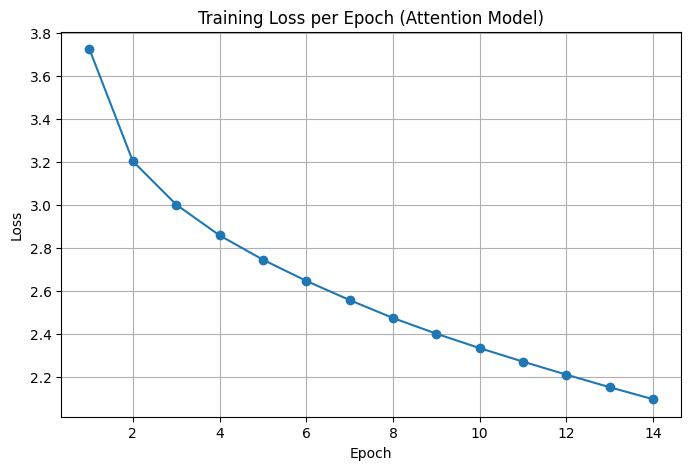

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o')
plt.title("Training Loss per Epoch (Attention Model)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [13]:
import os
print(os.getcwd())


C:\Users\User\PycharmProjects\Image-Captioning-Project\notebooks


In [14]:
best_epoch = 14
checkpoint_path = f"../checkpoint_epoch_{best_epoch}.pth"

checkpoint = torch.load(checkpoint_path, map_location=device)

encoder.load_state_dict(checkpoint["encoder"])
decoder.load_state_dict(checkpoint["decoder"])

encoder.to(device)
decoder.to(device)

encoder.eval()
decoder.eval()

print(f"Loaded checkpoint from epoch {checkpoint['epoch']+1}, loss = {checkpoint['loss']:.4f}")


Loaded checkpoint from epoch 14, loss = 2.0957


In [15]:
def generate_caption_beam(image, encoder, decoder, vocab, beam_size=3, max_len=25):
    """
    image: PIL image from your dataset
    returns: generated caption string
    """
    encoder.eval()
    decoder.eval()

    # preprocess image
    img = image_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_out = encoder(img)                  # (1, num_pixels, enc_dim)
        h, c = decoder.init_hidden_state(encoder_out)

    # Each element in sequences: (tokens, h, c, log_prob)
    sequences = [[ [vocab["<bos>"]], h, c, 0.0 ]]

    completed = []

    for _ in range(max_len):
        all_candidates = []

        for seq, h_prev, c_prev, score in sequences:
            last_token = seq[-1]

            # if already finished with <eos>, keep it as completed
            if vocab.get_itos()[last_token] == "<eos>":
                completed.append((seq, score))
                continue

            # embed last token
            last_token_tensor = torch.tensor([last_token], device=device)
            emb = decoder.embedding(last_token_tensor)   # (1, embed_dim)

            # attention
            context, _ = decoder.attention(encoder_out, h_prev)   # (1, enc_dim)
            gate = decoder.sigmoid(decoder.f_beta(h_prev))
            context = gate * context

            lstm_input = torch.cat([emb.squeeze(0), context.squeeze(0)], dim=0).unsqueeze(0)
            h_new, c_new = decoder.decode_step(lstm_input, (h_prev, c_prev))  # (1, dec_dim)

            scores = decoder.fc(h_new).log_softmax(dim=1)  # (1, vocab_size)
            topk = torch.topk(scores, beam_size)

            for idx, logprob in zip(topk.indices[0], topk.values[0]):
                new_seq = seq + [idx.item()]
                new_score = score + logprob.item()
                all_candidates.append((new_seq, h_new, c_new, new_score))

        # If no candidates (all ended with <eos>)
        if not all_candidates:
            break

        # Keep best beam_size sequences
        sequences = sorted(all_candidates, key=lambda x: x[3], reverse=True)[:beam_size]

    # If we have completed sequences, choose best by score
    if completed:
        best_seq, best_score = sorted(completed, key=lambda x: x[1], reverse=True)[0]
    else:
        best_seq, _, _, _ = sequences[0]

    # Convert to words
    itos = vocab.get_itos()
    words = []
    for idx in best_seq:
        tok = itos[idx]
        if tok in ("<bos>", "<pad>"):
            continue
        if tok == "<eos>":
            break
        words.append(tok)

    return " ".join(words)


In [21]:
import matplotlib.pyplot as plt
import os

def save_and_show_examples(dataset, encoder, decoder, vocab,
                           n=10, start_image_index=0, beam_size=5,
                           save_dir="saved_examples"):

    os.makedirs(save_dir, exist_ok=True)

    for i in range(n):
        idx = (start_image_index + i) * 10
        caption_tensor, img = dataset[idx]

        # generate caption using beam search
        pred_caption = generate_caption_beam(img, encoder, decoder, vocab, beam_size=beam_size)

        # create figure
        plt.figure(figsize=(5,5))
        plt.imshow(img)
        plt.axis("off")
        plt.title(pred_caption)

        # --- SAVE PNG ---
        filepath = os.path.join(save_dir, f"example_{i:03d}.png")
        plt.savefig(filepath, dpi=200, bbox_inches='tight')

        # --- SHOW ON SCREEN ---
        plt.show()

        print(f"Saved: {filepath}")


In [ ]:
save_and_show_examples(
    dataset=train_data,
    encoder=encoder,
    decoder=decoder,
    vocab=vocab_obj,
    n=10,
    start_image_index=0,
    beam_size=5
)


In [23]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
import numpy as np
import seaborn as sns
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer

smooth = SmoothingFunction().method1

In [23]:
def evaluate_all_metrics(encoder, decoder, dataset, vocab, num_samples=300):
    encoder.eval()
    decoder.eval()

    bleu1_list, bleu2_list, bleu3_list, bleu4_list = [], [], [], []
    meteor_list, rougeL_list = [], []

    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    for i in range(num_samples):
        base = i * 5

        # Ground-truth captions (5 per image)
        refs = []
        for k in range(5):
            caption_tensor, _ = dataset[base + k]
            tokens = [vocab.get_itos()[t] for t in caption_tensor]
            tokens = [w for w in tokens if w not in ["<bos>", "<eos>", "<pad>"]]
            refs.append(tokens)

        # Prediction
        _, img = dataset[base]
        pred = generate_caption_beam(img, encoder, decoder, vocab, beam_size=5)
        pred_tokens = pred.split()

        # BLEU 1–4
        bleu1_list.append(sentence_bleu(refs, pred_tokens, weights=(1,0,0,0), smoothing_function=smooth))
        bleu2_list.append(sentence_bleu(refs, pred_tokens, weights=(0.5,0.5,0,0), smoothing_function=smooth))
        bleu3_list.append(sentence_bleu(refs, pred_tokens, weights=(1/3,1/3,1/3,0), smoothing_function=smooth))
        bleu4_list.append(sentence_bleu(refs, pred_tokens, weights=(0.25,0.25,0.25,0.25), smoothing_function=smooth))

        # METEOR
        meteor_list.append(meteor_score(refs, pred_tokens))

        # ROUGE-L (use first reference for simplicity)
        rougeL = scorer.score(" ".join(pred_tokens), " ".join(refs[0]))['rougeL'].fmeasure
        rougeL_list.append(rougeL)

    return {
        "BLEU-1": np.array(bleu1_list),
        "BLEU-2": np.array(bleu2_list),
        "BLEU-3": np.array(bleu3_list),
        "BLEU-4": np.array(bleu4_list),
        "METEOR": np.array(meteor_list),
        "ROUGE-L": np.array(rougeL_list)
    }


In [24]:
metrics = evaluate_all_metrics(encoder, decoder, train_data, vocab_obj, num_samples=300)

for name, scores in metrics.items():
    print(f"{name}: mean={scores.mean():.4f}, std={scores.std():.4f}")


BLEU-1: mean=0.6647, std=0.1852
BLEU-2: mean=0.4695, std=0.2279
BLEU-3: mean=0.3254, std=0.2360
BLEU-4: mean=0.2324, std=0.2176
METEOR: mean=0.4679, std=0.1921
ROUGE-L: mean=0.3639, std=0.1669


# Histogram + KDE per metric

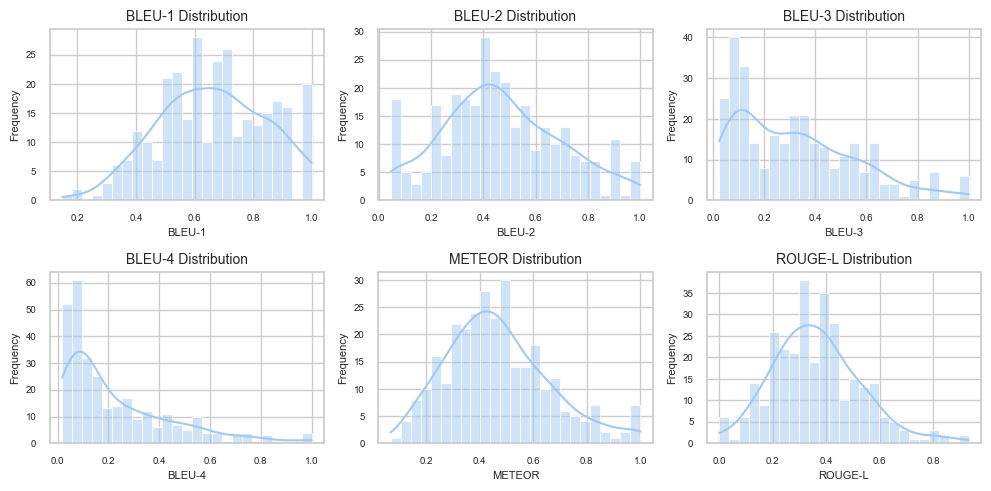

In [51]:
sns.set(style="whitegrid", palette="pastel", font_scale=0.8)

plt.rcParams.update({
    "axes.titlesize": 10,
    "axes.labelsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7
})

plt.figure(figsize=(10, 5))

for i, (name, scores) in enumerate(metrics.items()):
    plt.subplot(2, 3, i+1)
    sns.histplot(scores, bins=25, kde=True)

    plt.title(f"{name} Distribution")
    plt.xlabel(name)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


# Boxplots

# Correlation heatmap between metrics

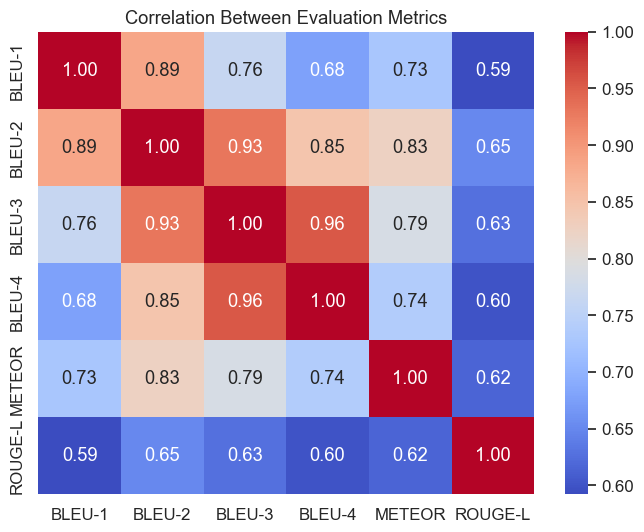

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_metrics.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Evaluation Metrics")
plt.show()


In [19]:
from PIL import Image
import torch

def caption_external_image(image_path, encoder, decoder, vocab, beam_size=5):
    # Load image
    img = Image.open(image_path).convert("RGB")

    transformed = image_transform(img).unsqueeze(0).to(device)

    # Encode
    with torch.no_grad():
        encoder_out = encoder(transformed)

    # Generate caption
    caption = generate_caption_beam(img, encoder, decoder, vocab, beam_size=beam_size)

    print("Caption:", caption)

    # Show
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(caption)
    plt.show()

    return caption


Caption: a group of children play in a park .


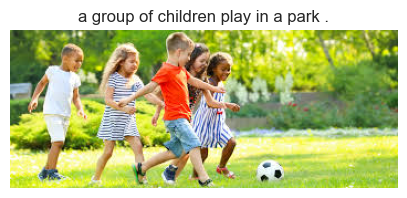

'a group of children play in a park .'

In [26]:
caption_external_image("../img_exp.jpg", encoder, decoder, vocab_obj, beam_size=5)
